
Source: https://www.kaggle.com/c/facial-keypoints-detection/overview

Source: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data


In [132]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [133]:
%cd /content/drive/My Drive/Emotion_dataset


/content/drive/My Drive/Emotion_dataset


In [134]:
# Import the necessary packages

import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

In [135]:
# load facial key points data
keyfacial_df = pd.read_csv('data.csv')
print(keyfacial_df)

      left_eye_center_x  ...                                              Image
0             66.033564  ...  238 236 237 238 240 240 239 241 241 243 240 23...
1             64.332936  ...  219 215 204 196 204 211 212 200 180 168 178 19...
2             65.057053  ...  144 142 159 180 188 188 184 180 167 132 84 59 ...
3             65.225739  ...  193 192 193 194 194 194 193 192 168 111 50 12 ...
4             66.725301  ...  147 148 160 196 215 214 216 217 219 220 206 18...
...                 ...  ...                                                ...
2135          67.180378  ...  191 191 191 190 189 185 184 120 54 34 19 24 31...
2136          65.724490  ...  19 19 19 18 13 7 3 4 3 1 3 9 11 12 12 13 10 9 ...
2137          68.430866  ...  31 40 47 31 54 58 63 100 86 80 82 75 79 86 90 ...
2138          64.152180  ...  7 1 5 1 3 20 12 0 5 8 6 18 13 9 8 12 12 11 4 8...
2139          66.683755  ...  68 19 19 23 19 26 23 16 8 15 9 9 17 16 15 27 2...

[2140 rows x 31 columns]


In [136]:
# Obtain relavant information about the dataframe
print(keyfacial_df.info())
#check NULL data
print(keyfacial_df.isnull().sum())
#we can see Last column consist of image and other column consist of features
#no Null values are present

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [137]:
print(keyfacial_df.iloc[0,30])
print(len(keyfacial_df.iloc[0,30]))

238 236 237 238 240 240 239 241 241 243 240 239 231 212 190 173 148 122 104 92 79 73 74 73 73 74 81 74 60 64 75 86 93 102 100 105 109 114 121 127 132 134 137 137 140 139 138 137 137 140 141 143 144 147 148 149 147 147 148 145 147 144 146 147 147 143 134 130 130 128 116 104 98 90 82 78 85 88 86 80 77 87 108 111 115 128 133 188 242 252 250 248 251 250 250 250 235 238 236 238 238 237 238 242 241 239 237 233 215 195 187 156 119 103 93 78 68 73 75 75 72 75 70 61 66 77 91 96 106 108 113 120 125 131 134 138 135 138 139 145 144 144 142 140 141 141 148 147 150 149 152 151 149 150 147 148 144 148 144 146 146 143 139 128 132 135 128 112 104 97 87 78 79 83 85 83 75 75 89 109 111 117 117 130 194 243 251 249 250 249 250 251 237 236 237 238 237 238 241 238 238 238 241 221 195 187 163 124 106 95 81 68 70 73 73 72 73 69 65 74 82 94 103 110 111 119 127 135 140 139 144 144 145 143 143 143 146 144 144 147 146 148 147 150 146 147 150 150 149 147 147 144 147 144 149 146 144 144 144 140 131 133 133 125 110 1

In [138]:
#convert the image to its original size ie 96x96 by forming an array and reshaping it to the required size
keyfacial_df['Image'] = keyfacial_df['Image'].apply(lambda x: np.fromstring(x, dtype = int, sep = ' ').reshape(96, 96))

In [139]:
# Obtain the Shape of the image
keyfacial_df['Image'][0].shape

(96, 96)

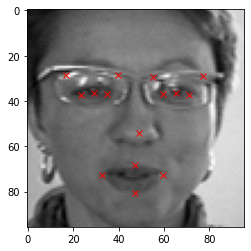

In [140]:
#plot a random image from the dataset

i = np.random.randint(1, len(keyfacial_df))
plt.imshow(keyfacial_df['Image'][i], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')


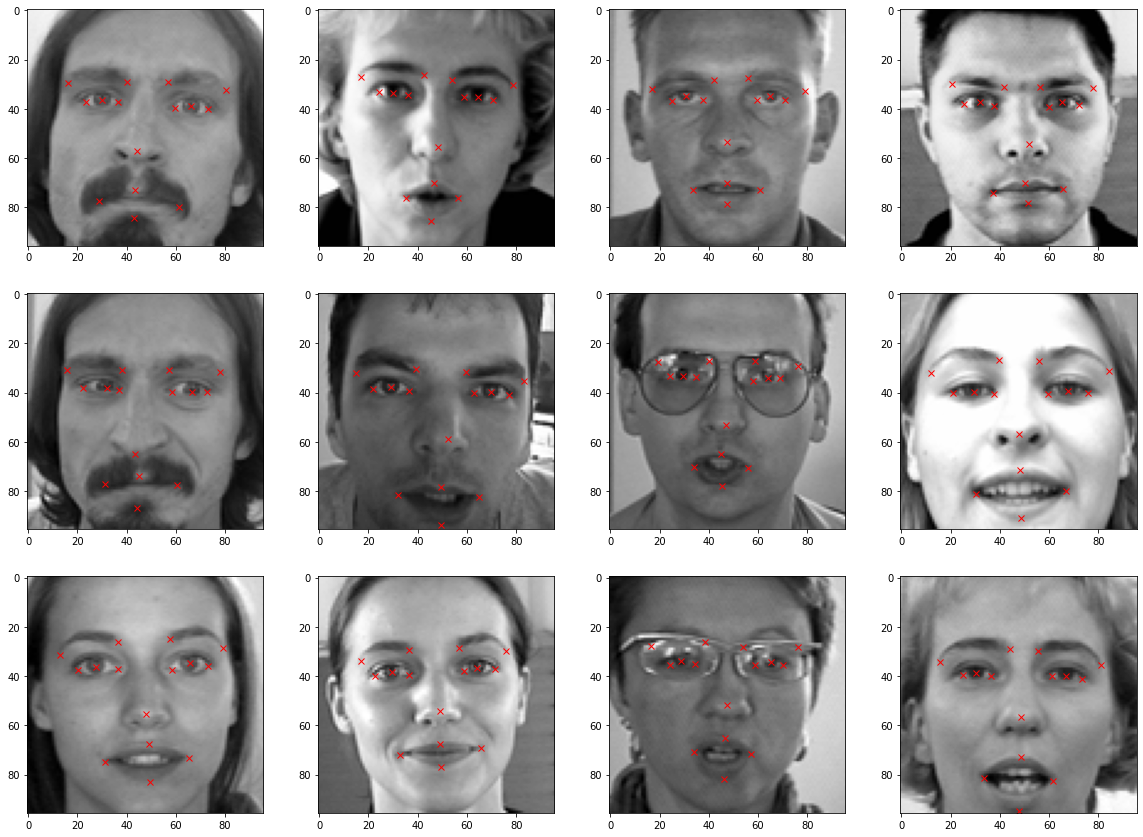

In [141]:
# Let's view more images in a grid format
fig = plt.figure(figsize=(20, 20))

for i in range(12):
    ax = fig.add_subplot(4, 4, i + 1)    
    image = plt.imshow(keyfacial_df['Image'][i],cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')
    

In [142]:
# Create a new copy of the dataframe
import copy
facial_df_copy = copy.copy(keyfacial_df)
columns = facial_df_copy.columns[:-1]

In [143]:
#image usgmentation through horizontal flip
facial_df_copy['Image'] = facial_df_copy['Image'].apply(lambda x: np.flip(x, axis = 1))
#axis=1 because flip is done laong y axis
#fetures need a subtraction from 96 only in column containg x values since y is unchanged
for i in range(30):
  if i%2 == 0:
    facial_df_copy[columns[i]] = facial_df_copy[columns[i]].apply(lambda x: 96. - float(x) )

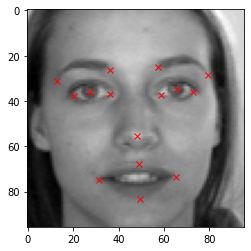

In [144]:
# Show the Original image
plt.imshow(keyfacial_df['Image'][8], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[8][j-1], keyfacial_df.loc[8][j], 'rx')

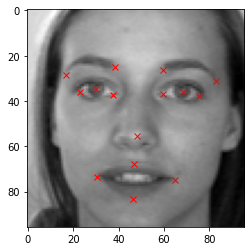

In [145]:
# Show the Horizontally flipped image
plt.imshow(facial_df_copy['Image'][8],cmap='gray')
for j in range(1, 31, 2):
        plt.plot(facial_df_copy.loc[8][j-1], facial_df_copy.loc[8][j], 'rx')

In [ ]:
# Concatenate the original dataframe with the augmented dataframe
augmented_df = np.concatenate((keyfacial_df, facial_df_copy))

In [146]:
# Randomingly increasing the brightness of the images
import random

facial_df_copy = copy.copy(keyfacial_df)
facial_df_copy['Image'] = facial_df_copy['Image'].apply(lambda x:np.clip(random.uniform(1.3, 2)* x, 0.0, 255.0))
augmented_df = np.concatenate((augmented_df, facial_df_copy))
print(augmented_df.shape)

(8560, 31)


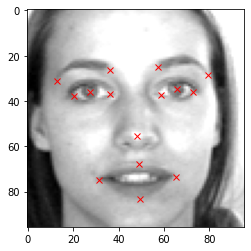

In [147]:
# Show Image with increased brightness

plt.imshow(facial_df_copy['Image'][8], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(facial_df_copy.loc[8][j-1], facial_df_copy.loc[8][j], 'rx')

In [148]:
img = augmented_df[:,30]
# Normalize the images
img = img/255.
# Create an empty array of shape (x, 96, 96, 1) to feed the model
X = np.empty((len(img), 96, 96, 1))
# Iterate through the img list and add image values to the empty array after expanding it's dimension from (96, 96) to (96, 96, 1)
for i in range(len(img)):
  X[i,] = np.expand_dims(img[i], axis = 2)
# Convert the array type to float32
X = np.asarray(X).astype(np.float32)
print(X.shape)

(8560, 96, 96, 1)


In [149]:
# Obtain the value of x & y coordinates which are to used as target.
y = augmented_df[:,:30]
y = np.asarray(y).astype(np.float32)
y.shape

(8560, 30)

In [150]:
# Split the data into train and test data
from sklearn.utils import shuffle
X, y=shuffle(X,y)
X, y=shuffle(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)



In [151]:
def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [180]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2 - stage
X = res_block(X, filter= [64,64,256], stage= 2)

# 3 - stage
#X = res_block(X, filter= [128,128,512], stage= 3)


# Average Pooling
X = AveragePooling2D((2,2), name = 'Average_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(30, activation = 'relu')(X)


model_facialKeyPoints = Model( inputs= X_input, outputs = X)
#model_facialKeyPoints.summary()

In [182]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.0005, beta_1=0.95, beta_2=0.999)
model_facialKeyPoints.compile(loss = "mean_squared_error", optimizer = opt, metrics=['accuracy'] )


In [183]:
checkpointer = ModelCheckpoint(filepath = "FacialKeyPoints_weights.hdf5", verbose = 1, save_best_only = True)

In [184]:
history = model_facialKeyPoints.fit(X_train, y_train, batch_size = 32, epochs = 100, validation_split = 0.05,callbacks=[checkpointer])

Epoch 1/100
204/204 [==============================] - ETA: 0s - loss: 202.9899 - accuracy: 0.5048
Epoch 00001: val_loss improved from inf to 438.28122, saving model to FacialKeyPoints_weights.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


204/204 [==============================] - 14s 59ms/step - loss: 202.9899 - accuracy: 0.5048 - val_loss: 438.2812 - val_accuracy: 0.6676
Epoch 2/100
203/204 [============================>.] - ETA: 0s - loss: 129.9307 - accuracy: 0.5961
Epoch 00002: val_loss improved from 438.28122 to 181.34564, saving model to FacialKeyPoints_weights.hdf5
204/204 [==============================] - 11s 55ms/step - loss: 129.9035 - accuracy: 0.5960 - val_loss: 181.3456 - val_accuracy: 0.6676
Epoch 3/100
204/204 [==============================] - ETA: 0s - loss: 74.9032 - accuracy: 0.5997
Epoch 00003: val_loss improved from 181.34564 to 61.29081, saving model to FacialKeyPoints_weights.hdf5
204/204 [==============================] - 11s 54ms/step - loss: 74.9032 - accuracy: 0.5997 - val_loss: 61.2908 - val_accuracy: 0.6647
Epoch 4/100
203/204 [============================>.] - ETA: 0s - loss: 48.9133 - accuracy: 0.6053
Epoch 00004: val_loss did not improve from 61.29081
204/204 [==========================

In [185]:
# save the model architecture to json file for future use

model_json = model_facialKeyPoints.to_json()
with open("FacialKeyPoints-model1.json","w") as json_file:
  json_file.write(model_json)


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [186]:
with open('FacialKeyPoints-model1.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model architecture 
model_1_facialKeyPoints = tf.keras.models.model_from_json(json_savedModel)
model_1_facialKeyPoints.load_weights('FacialKeyPoints_weights.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_1_facialKeyPoints.compile(loss="mean_squared_error", optimizer= adam , metrics = ['accuracy'])

In [187]:
# Evaluate the model

result = model_1_facialKeyPoints.evaluate(X_test, y_test)
print("Accuracy : {}".format(result[1]))

54/54 [==============================] - 1s 15ms/step - loss: 33.3803 - accuracy: 0.7775
Accuracy : 0.7774532437324524


In [188]:
# Get the model keys 
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [189]:
prediction=model_1_facialKeyPoints.predict(X_test)

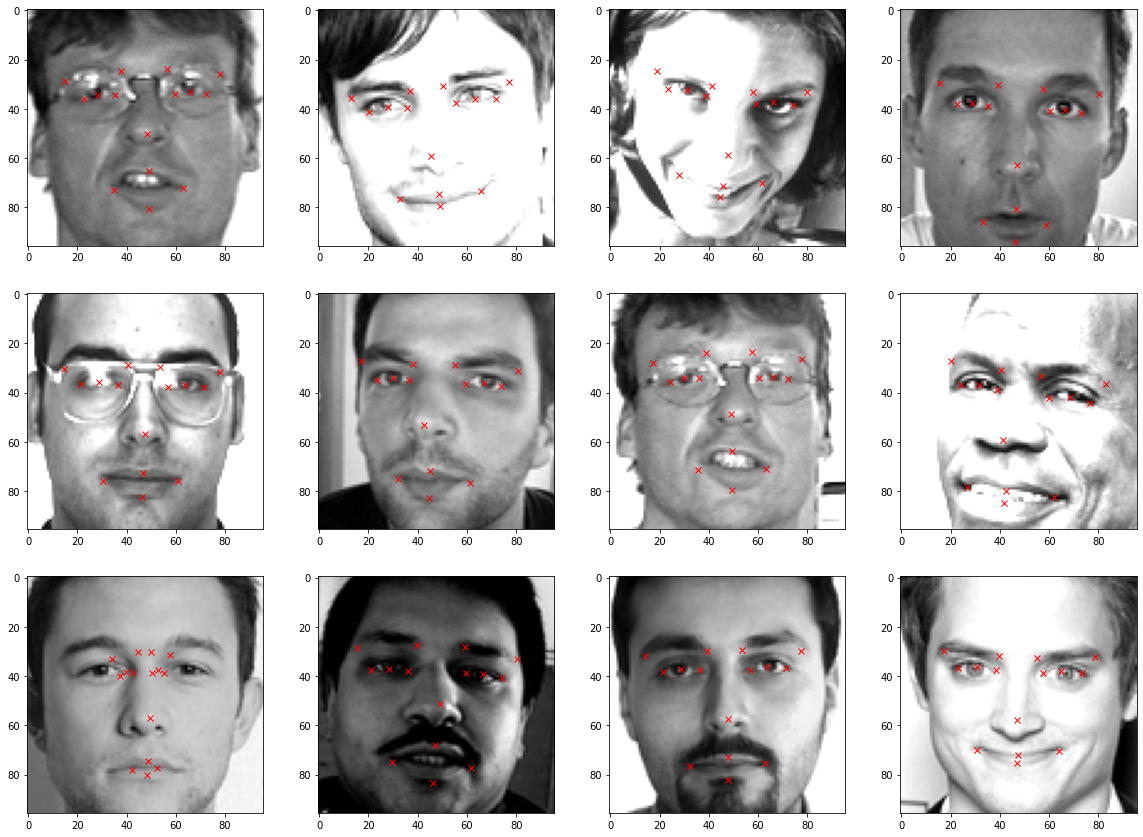

In [191]:
# Plot the training artifacts
fig = plt.figure(figsize=(20, 20))

for i in range(12):
    ax = fig.add_subplot(4, 4, i + 1)
    plt.imshow(np.squeeze(X_test[i]), cmap='gray')
    for j in range(1, 31, 2):
        plt.plot(prediction[i][j-1], prediction[i][j], 'rx')